In [1]:
from pandas import read_csv,DataFrame,read_excel, merge,concat, Series
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

%load_ext autoreload
%autoreload
from functions_economic_analysis import *

In [2]:
datacsv          = "peru_clusters_july/"
data_peru        = "country_data/"
list_csv         = os.listdir(datacsv)

In [3]:
figures = "figures_new/"
if not os.path.exists(figures):
    os.makedirs(figures)

In [4]:
baseline = read_csv(datacsv+"OD_baseline_Peru.csv")
baseline.index = baseline.Name
baseline["O"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))
baseline["D"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(2))

### calculates weights for each node

In [5]:
nodes1 = read_excel(data_peru+"NODE_CID.xlsx","NODES_CID")
nodes2 = read_excel(data_peru+"NODES_10km_TPDA.xlsx","NODES_10km_TPDA")

nodes = merge(nodes1, nodes2, on='CID', how='outer')

#### the function below calculates the weight of a OD pair based on the gravity model

In [6]:
baseline["Ot"] = baseline.O.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Dt"] = baseline.D.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Opop"] = baseline.O.replace(nodes.set_index('CID')["Population Headcount"])
baseline["Dpop"] = baseline.D.replace(nodes.set_index('CID')["Population Headcount"])

In [7]:
baseline.ix[baseline.Total_KM!=0,'weights']=baseline.ix[baseline.Total_KM!=0,'Ot']\
                                            *baseline.ix[baseline.Total_KM!=0,'Dt']\
                                            /baseline.ix[baseline.Total_KM!=0,'Total_KM']**2
baseline.weights.fillna(0,inplace=True)

In [8]:
info_links = read_excel(data_peru+"Traffic_Link_Final_PER_jun03.xlsx","Traffic_Link_Final")
huaycos = read_csv("huaycos peru/Traffic_Link_Final_huaycos.csv")
huaycos.index = huaycos.ScenarioID
info_links["huaycos"] = huaycos.Huaycos
#info_links = read_excel(datacsv+"allinfo.xlsx","Traffic_Link_AllInfo")

In [9]:
cluster_centralv2   = read_csv(datacsv+"links_Cluster_Centralv2.csv")

In [10]:
costs_ini = DataFrame(columns=["scenarioID","partial_or_full","part_ruc_increase","ruc_increase","missingroutes",\
                           "num_aff_routes","cost_with_traffic","km_diff","improved_2nd"])
for file in list_csv:
    if ".csv" not in file:
        continue
    if "second_best" in file:
        continue
    if file=="OD_baseline_Peru.csv":
        continue
    if ("links" in file):
        continue
    if ("Centralv2" not in file)&("centralv2" not in file):
        continue
    if "alt" in file:
        improved_2nd=1
        if ("partial" in file):
            partial_or_full="partial"
            n      = (re.search('Cluster_(.*)_alt_partial.csv', file).group(1))
            part_ruc_increase = 0.5
        if ("full" in file):
            partial_or_full='full'
            n      = (re.search('Cluster_(.*)_alt_full.csv', file).group(1))
            part_ruc_increase = 0.
    else:
        improved_2nd=0
        if ("partial" in file):
            partial_or_full="partial"
            n      = (re.search('Cluster_(.*)_partial.csv', file).group(1))
            part_ruc_increase = 0.5
        if ("full" in file):
            partial_or_full='full'
            n      = (re.search('Cluster_(.*)_full.csv', file).group(1))
            part_ruc_increase = 0.
    scenar = read_csv(datacsv+file)
    scenar.index = scenar.Name

    missingroutes = len(baseline)-len(scenar)
    # we do not take into account the routes that don't have a second best solution
    baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
    # we select only routes that get affected by the disruption
    affected_routes = (np.round(scenar.Total_Ta_r/baseline_nm.Total_Ta_r,3)!=1)&(baseline_nm.Total_Ta_r>0)
    subscenar = scenar.ix[affected_routes,:]
    subscenar["weights"] = baseline_nm.weights

    traffic = info_links.ix[eval("cluster_"+n).ScenarioID,"TPDA"].max()

    diff_ruc_baseline   = (subscenar.Total_Ta_r-\
                           baseline_nm.ix[affected_routes,"Total_Ta_r"])
    diff_km_from_baseline = (subscenar.Total_KM-baseline_nm.ix[affected_routes,"Total_KM"])
    diff_tot_baseline   = (traffic*diff_ruc_baseline)

    ruc_increase      = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
    km_diff = np.sum(diff_km_from_baseline*subscenar.weights)/subscenar.weights.sum()
    cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()

    costs_ini.loc[len(costs_ini),:] = [n,partial_or_full,part_ruc_increase,\
                                       ruc_increase,missingroutes,sum(affected_routes),\
                                       cost_with_traffic,km_diff,improved_2nd]

C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
costs_ini

,scenarioID,partial_or_full,part_ruc_increase,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff,improved_2nd
0,centralv2,full,0,1.892001,180,1764,10519.52,1.218482,1
1,centralv2,partial,0.5,-0.6941163,0,1846,-3859.287,0.02429041,1
2,centralv2,full,0,73.79377,180,368,410293.4,26.89949,0
3,centralv2,partial,0.5,3.43787,0,412,19114.56,-0.02860785,0


In [12]:
scenar = read_csv(datacsv+"Cluster_centralv2_full.csv")
scenar.index = scenar.Name
missing_routes = [r not in scenar.Name for r in baseline.Name]

In [13]:
sum(missing_routes)

180

In [14]:
origins = baseline.ix[missing_routes,"Name"].apply(lambda s: re.search("(.*) - (.*)",s).group(1))
cuts = origins.value_counts()

In [15]:
cuts

C192    90
B5       1
C185     1
C212     1
C179     1
C178     1
C186     1
C213     1
C219     1
C165     1
P4       1
C200     1
A9       1
C175     1
A8       1
A7       1
A6       1
C184     1
A4       1
C182     1
C183     1
C180     1
C174     1
C176     1
P1       1
C210     1
C190     1
C193     1
C195     1
C194     1
        ..
C208     1
B2       1
B3       1
B1       1
B6       1
B7       1
A13      1
C223     1
A3       1
A14      1
C209     1
C201     1
C218     1
C205     1
C204     1
C207     1
C206     1
A2       1
C188     1
C203     1
C202     1
C216     1
C221     1
C163     1
C164     1
A1       1
C166     1
C167     1
C168     1
C191     1
dtype: int64

In [16]:
city = read_csv("country_data/NODES_Peru_CITY.csv")
city.ix[[i in ["C192"] for i in city.CID],"CITY_NAME"]

29    Chaclacayo
Name: CITY_NAME, dtype: object

In [17]:
for n in ["centralv2"]:
    for col in ["KM"]:
        costs_ini.ix[costs_ini.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].sum()
    for col in ['Elevation (m)','TPDA']:
        costs_ini.ix[costs_ini.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].max()
    for climat in ['EU_historical']:
            for RP in [5,10,25,50,100,250,500,1000]:
                col = "{}_RP{} (dm)".format(climat,RP)
                costs_ini.ix[costs_ini.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].max()
    for col in ['CLASS', 'COND1', 'Identifier',\
               'LANES', 'OPTIMAL', 'STATUS', 'SURFACE1','TERRAIN','OD']:
        costs_ini.ix[costs_ini.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].value_counts().index[0]

In [18]:
terrain_corr = read_csv("terrain_correspondance.csv")

In [19]:
costs_ini = costs_ini.merge(terrain_corr,on=["TERRAIN"],how="inner")

In [20]:
intervention_costs = read_csv("interventions_costs_usdperkm_sep1.csv")

In [21]:
costs_all = costs_ini.merge(intervention_costs,on=["CLASS","SURFACE1","terrain2"],how="inner")

In [22]:
sb_centralv2   = DataFrame()
for file in list_csv:
    if ("second_best" in file)&("centralv2" in file):
        second_best = read_csv(datacsv+file)
        aa = re.search("second_best_(.*)_(.*)_(.*).csv",file)
        link = aa.group(1).lower()
        exec("sb_"+link+"= sb_"+link+".append(second_best)")

In [23]:
print(sb_centralv2.KM.sum())

501.596151397


In [24]:
sb_centralv2 = sb_centralv2.merge(terrain_corr,on=['TERRAIN'],how='inner').merge(intervention_costs,on=['terrain2','SURFACE1','CLASS'],how='inner')

In [25]:
sb_centralv2.groupby(['CLASS','SURF','CONDITION','LANES','TERRAIN']).count().NAME_0

CLASS      SURF       CONDITION  LANES  TERRAIN                              
Primary    Paved      Bueno      4      Bendy and gently undulating               4
                                        Bendy and severely undulating             8
                                        Mostly straight and gently undulating    15
                                        Straight and level                        2
                                        Winding and gently undulating             1
                                 6      Bendy and generally level                 1
                                        Bendy and gently undulating               4
                                        Bendy and severely undulating             6
                                        Mostly straight and gently undulating     3
                      Malo       4      Mostly straight and gently undulating     3
                      Regular    4      Bendy and gently undulating               

In [26]:
%load_ext autoreload
%autoreload
from functions_economic_analysis_el_nino import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
bau = DataFrame()
for duration_huaycos in range(1,30,2):
    bau=bau.append(run_scenarios_huaycos(costs_all,"centralv2",1,"bau",duration_huaycos),ignore_index=True)

In [28]:
run_scenarios_huaycos(costs_all,"centralv2",1,"bau",1)

,intervention,duration_huaycos,user_annual_losses,expost_annual_losses
0,bau,1,6708053,5.480895e+07


In [30]:
calc_npv_huaycos(20,costs_all,"centralv2","redundancy",0.03,1,sb_centralv2,0.03,1)

,intervention,duration_huaycos,npv,disc_reduced_losses,interv_cost
0,redundancy,1,1.596203e+09,2.319997e+09,7.237944e+08


In [32]:
from pyDOE import *

In [33]:
ranges = DataFrame(columns=["variable","min","max"])
ranges.loc[0,:]=["duration_huaycos",1,90]
ranges.loc[1,:]=["disc_rate",0.03,0.2]
#ranges.loc[2,:]=["growth",0.0,0.05]

In [34]:
lhsample= lhs(2,samples=500,criterion="corr")

new candidate solution found with max,abs corrcoef = 1.0000000000000002


In [35]:
scenarios=lhsample*np.diff(ranges[['min','max']].values).T+ranges['min'].values
scenarios=DataFrame(scenarios,columns=ranges['variable'])

In [36]:
import numpy as np
npv_redundancy0=DataFrame()
for i in scenarios.index:
    growth = 0.0
    [duration_huaycos,disc_rate]=scenarios.loc[i,:].values
    temp = calc_npv_huaycos(20,costs_all,"centralv2","redundancy",disc_rate,1,sb_centralv2,growth,duration_huaycos)
    temp.ix[:,"disc_rate"]=disc_rate
    temp.ix[:,"growth"]=growth
    npv_redundancy0 = npv_redundancy0.append(temp,ignore_index=True)

In [37]:
npv_redundancy3=DataFrame()
for i in scenarios.index:
    growth = 0.03
    [duration_huaycos,disc_rate]=scenarios.loc[i,:].values
    temp = calc_npv_huaycos(20,costs_all,"centralv2","redundancy",disc_rate,1,sb_centralv2,growth,duration_huaycos)
    temp.ix[:,"disc_rate"]=disc_rate
    temp.ix[:,"growth"]=growth
    npv_redundancy3 = npv_redundancy3.append(temp,ignore_index=True)

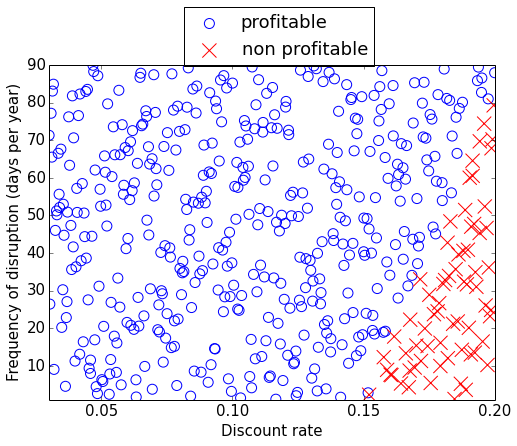

In [51]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

prof = npv_redundancy0.npv>0
ax.scatter(npv_redundancy0.ix[prof,"disc_rate"],npv_redundancy0.ix[prof,"duration_huaycos"],\
           marker='o',s=100,facecolors='none',edgecolors="blue",label="profitable")
ax.scatter(npv_redundancy0.ix[~prof,"disc_rate"],npv_redundancy0.ix[~prof,"duration_huaycos"],\
           marker='x',s=200,c='red',label="non profitable")
ax.set_xlim([0.03,0.2])
ax.set_ylim([1,90])
plt.legend(bbox_to_anchor=(0.25,0.7,0.5,0.5),scatterpoints=1)
#plt.xlabel("Tasa de descuento")
plt.xlabel("Discount rate")
#plt.ylabel("Duración de la ruptura (days per year)")
plt.ylabel("Frequency of disruption (days per year)")
plt.savefig(figures+"redundancy_carretera_central_0growth.png",bbox_inches="tight",dpi=100)

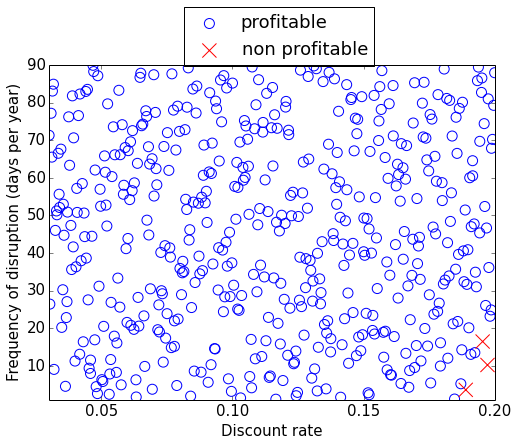

In [50]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

prof = npv_redundancy3.npv>0
ax.scatter(npv_redundancy3.ix[prof,"disc_rate"],npv_redundancy3.ix[prof,"duration_huaycos"],\
           marker='o',s=100,facecolors='none',edgecolors="blue",label="profitable")
ax.scatter(npv_redundancy3.ix[~prof,"disc_rate"],npv_redundancy3.ix[~prof,"duration_huaycos"],\
           marker='x',s=200,c='red',label="non profitable")
ax.set_xlim([0.03,0.2])
ax.set_ylim([1,90])
plt.legend(bbox_to_anchor=(0.25,0.7,0.5,0.5),scatterpoints=1)
#plt.xlabel("Tasa de descuento")
plt.xlabel("Discount rate")
#plt.ylabel("Duración de la ruptura (days per year)")
plt.ylabel("Frequency of disruption (days per year)")
plt.savefig(figures+"redundancy_carretera_central_3growth.png",bbox_inches="tight",dpi=100)

In [41]:
npv_tunnel0=DataFrame()
for i in scenarios.index:
    growth = 0.0
    [duration_huaycos,disc_rate]=scenarios.loc[i,:].values
    temp = calc_npv_huaycos(20,costs_all,"centralv2","tunnel",disc_rate,1,sb_centralv2,growth,duration_huaycos)
    temp.ix[:,"disc_rate"]=disc_rate
    temp.ix[:,"growth"]=growth
    npv_tunnel0 = npv_tunnel0.append(temp,ignore_index=True)

In [42]:
npv_tunnel3=DataFrame()
for i in scenarios.index:
    growth = 0.03
    [duration_huaycos,disc_rate]=scenarios.loc[i,:].values
    temp = calc_npv_huaycos(20,costs_all,"centralv2","tunnel",disc_rate,1,sb_centralv2,growth,duration_huaycos)
    temp.ix[:,"disc_rate"]=disc_rate
    temp.ix[:,"growth"]=growth
    npv_tunnel3 = npv_tunnel3.append(temp,ignore_index=True)

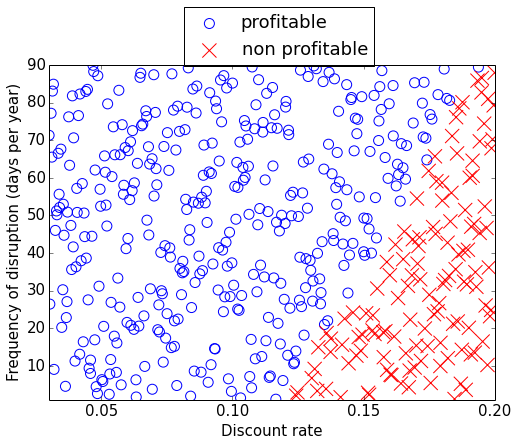

In [52]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

prof = npv_tunnel3.npv>0
ax.scatter(npv_tunnel3.ix[prof,"disc_rate"],npv_tunnel3.ix[prof,"duration_huaycos"],\
           marker='o',s=100,facecolors='none',edgecolors="blue",label="profitable")
ax.scatter(npv_tunnel3.ix[~prof,"disc_rate"],npv_tunnel3.ix[~prof,"duration_huaycos"],\
           marker='x',s=200,c='red',label="non profitable")
ax.set_xlim([0.03,0.2])
ax.set_ylim([1,90])
plt.legend(bbox_to_anchor=(0.25,0.7,0.5,0.5),scatterpoints=1)
#plt.xlabel("Tasa de descuento")
plt.xlabel("Discount rate")
#plt.ylabel("Duración de la ruptura (days per year)")
plt.ylabel("Frequency of disruption (days per year)")
plt.savefig(figures+"tunnel_carretera_central_3growth.png",bbox_inches="tight",dpi=100)

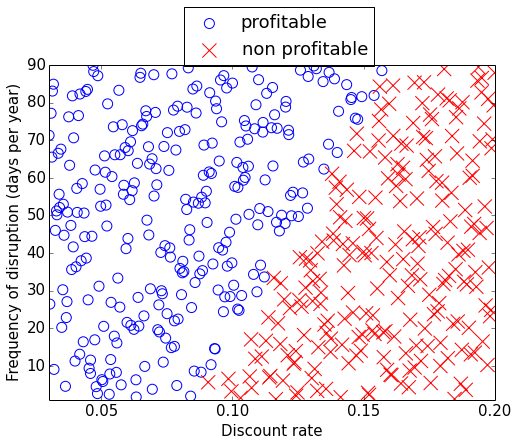

In [53]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

prof = npv_tunnel0.npv>0
ax.scatter(npv_tunnel0.ix[prof,"disc_rate"],npv_tunnel0.ix[prof,"duration_huaycos"],\
           marker='o',s=100,facecolors='none',edgecolors="blue",label="profitable")
ax.scatter(npv_tunnel0.ix[~prof,"disc_rate"],npv_tunnel0.ix[~prof,"duration_huaycos"],\
           marker='x',s=200,c='red',label="non profitable")
ax.set_xlim([0.03,0.2])
ax.set_ylim([1,90])
plt.legend(bbox_to_anchor=(0.25,0.7,0.5,0.5),scatterpoints=1)
#plt.xlabel("Tasa de descuento")
plt.xlabel("Discount rate")
#plt.ylabel("Duración de la ruptura (days per year)")
plt.ylabel("Frequency of disruption (days per year)")
plt.savefig(figures+"tunnel_carretera_central_0growth.png",bbox_inches="tight",dpi=100)